In [200]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [201]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Sopprimi i RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Studio algoritmi per trovare i prezzi di riferimento per il calcolo delle variazioni di prezzo

In [202]:
# Funzione per generare prezzi casuali basati su una distribuzione delle variazioni
def genera_prezzi(num_giorni, distribuzione_variazioni):
    np.random.seed(0)  # Per riproducibilità
    prezzi = [100]  # Prezzo iniziale
    variazioni = np.random.choice(list(distribuzione_variazioni.keys()), 
                                  size=num_giorni-1, 
                                  p=list(distribuzione_variazioni.values()))
    
    for variazione in variazioni:
        prezzi.append(prezzi[-1] * (1 + variazione))
    
    return pd.DataFrame({'Timestamp': pd.date_range(start='2023-01-01', periods=num_giorni, freq='D'), 
                         'Price': prezzi})

In [203]:
# Distribuzione delle variazioni (esempio)
distribuzione_variazioni = {
    -0.05: 0.1,
    -0.02: 0.2,
    -0.01: 0.2,
    0.01: 0.2,
    0.02: 0.2,
    0.05: 0.1
}

# Genera prezzi
num_giorni = 100
dati = genera_prezzi(num_giorni, distribuzione_variazioni)

# Calcola variazioni
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

# Parametri
soglia_calcolo_variazioni_discesa = 0.05
soglia_calcolo_variazioni_salita = 0.05

prezzi_riferimento_discesa = []
variazione_cumulata = 1
gia_trovato = False
cont = 0
for j in range(len(dati), 0, -1):
    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
    if pd.isna(variazione_giorno_precedente):
        continue
    if variazione_giorno_precedente < 1:
        variazione_cumulata = 1
        cont = 0
        gia_trovato = False
        continue
    else:
        variazione_cumulata *= variazione_giorno_precedente
        if variazione_cumulata != variazione_giorno_precedente:
            cont += 1
        if variazione_cumulata - 1 >= soglia_calcolo_variazioni_discesa and not gia_trovato:
            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
            prezzi_riferimento_discesa.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
            variazione_cumulata = 1
            cont = 0
            gia_trovato = True

prezzi_riferimento_salita = []
variazione_cumulata = 1
gia_trovato = False
cont = 0
for j in range(len(dati), 0, -1):
    variazione_giorno_precedente = dati['Variazione'].iloc[j-1]
    if pd.isna(variazione_giorno_precedente):
        continue
    if variazione_giorno_precedente > 1:
        variazione_cumulata = 1
        cont = 0
        gia_trovato = False
        continue
    else:
        variazione_cumulata *= variazione_giorno_precedente
        if variazione_cumulata != variazione_giorno_precedente:
            cont += 1
        if 1 - variazione_cumulata >= soglia_calcolo_variazioni_salita and not gia_trovato:
            prezzo_riferimento = dati['Price'].iloc[j+cont-1]
            prezzi_riferimento_salita.append((dati['Timestamp'].iloc[j+cont-1], prezzo_riferimento))
            variazione_cumulata = 1
            cont = 0
            gia_trovato = True




# Creazione del grafico con Plotly
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(x=dati['Timestamp'], y=dati['Price'], 
                         mode='lines', name='Prezzi',
                         line=dict(color='blue', width=2)))

# Aggiungi punti di riferimento discesa (in verde)
for timestamp, prezzo_riferimento in prezzi_riferimento_discesa:
    fig.add_trace(go.Scatter(
        x=[timestamp], y=[prezzo_riferimento],
        mode='markers+text', name='Riferimento Discesa',
        marker=dict(color='green', size=10),
        text=[f'{prezzo_riferimento:.2f}'],
        textposition='top center',
        hoverinfo='text+name'  # Mostra testo e nome al passaggio del mouse
    ))

# Aggiungi punti di riferimento salita (in rosso)
for timestamp, prezzo_riferimento in prezzi_riferimento_salita:
    fig.add_trace(go.Scatter(
        x=[timestamp], y=[prezzo_riferimento],
        mode='markers+text', name='Riferimento Salita',
        marker=dict(color='red', size=10),
        text=[f'{prezzo_riferimento:.2f}'],
        textposition='top center',
        hoverinfo='text+name'  # Mostra testo e nome al passaggio del mouse
    ))

# Configurazione del layout del grafico
fig.update_layout(
    title='Prezzi generati con punti di riferimento per le discese (in verde) e per le salite (in rosso)',
    xaxis_title='Data',
    yaxis_title='Prezzo',
    hovermode='closest',
    template='plotly_white',
    width=1600,
    height=7/10 * 1600,
    showlegend=False,
    # legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    
    # Aggiungi il range slider per l'asse X
    xaxis=dict(
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Mostra il grafico
fig.show()

In [204]:
dati[:20]

,Timestamp,Price,Variazione
0,2023-01-01,100.000000,NaN
1,2023-01-02,101.000000,1.01
2,2023-01-03,103.020000,1.02
3,2023-01-04,104.050200,1.01
4,2023-01-05,105.090702,1.01
5,2023-01-06,104.039795,0.99
6,2023-01-07,105.080193,1.01
7,2023-01-08,104.029391,0.99
8,2023-01-09,106.109979,1.02
9,2023-01-10,111.415478,1.05


## Lettura dati Bitcoin

In [205]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [206]:
# dati = pd.read_csv('Bitcoin (€) da yfinance dal 06-05-2022 alle 21 al 05-05-2024 alle 19 con granularità oraria.csv')
# dati = dati[['Datetime', 'Close']]
# dati = dati.rename(columns = {'Datetime':'Timestamp', 'Close': 'Price'})
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
# dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d %H')
# dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d %H')
# dati

In [207]:
# Bull market
# data_inizio = '2020-12-01'
# data_fine = '2021-04-30'

# Mercato laterale
# data_inizio = '2022-07-01'
# data_fine = '2022-10-31'

# Bear market
data_inizio = '2021-05-01'
data_fine = '2021-07-31'

indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-05-01,48110.046875
1,2021-05-02,47088.570312
2,2021-05-03,47432.769531
3,2021-05-04,44387.261719
4,2021-05-05,47823.058594
...,...,...
87,2021-07-27,33336.066406
88,2021-07-28,33764.222656
89,2021-07-29,33643.082031
90,2021-07-30,35590.078125


In [208]:
# data_inizio = '2023-06-01 00'
# data_fine = '2023-12-01 00'
# indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
# indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
# dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
# dati

In [209]:
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

### Eventuale cambio dati

In [210]:
def calcola_prezzo(t):
    return dati['Price'][t] #1000 - t + 100 * math.sin(2*math.pi * t / 4)

In [211]:
dati['Price'] = dati.index.map(calcola_prezzo)
dati

,Timestamp,Price,Variazione
0,2021-05-01,48110.046875,NaN
1,2021-05-02,47088.570312,0.978768
2,2021-05-03,47432.769531,1.007310
3,2021-05-04,44387.261719,0.935793
4,2021-05-05,47823.058594,1.077405
...,...,...,...
87,2021-07-27,33336.066406,1.053977
88,2021-07-28,33764.222656,1.012844
89,2021-07-29,33643.082031,0.996412
90,2021-07-30,35590.078125,1.057872


## Algoritmo

In [212]:
# Funzione per calcolare l'ultimo prezzo di riferimento discesa
def calcola_prezzo_riferimento_discesa(dati, soglia_discesa):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente < 1:  # Prezzo in discesa
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if variazione_cumulata - 1 >= soglia_discesa:
                # Se la variazione supera la soglia, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

# Funzione per calcolare l'ultimo prezzo di riferimento salita
def calcola_prezzo_riferimento_salita(dati, soglia_salita):
    variazione_cumulata = 1
    cont = 0

    for j in range(len(dati), 0, -1):
        variazione_giorno_precedente = dati['Variazione'].iloc[j-1]

        if pd.isna(variazione_giorno_precedente):
            continue

        if variazione_giorno_precedente > 1:  # Prezzo in salita
            variazione_cumulata = 1
            cont = 0
        else:
            variazione_cumulata *= variazione_giorno_precedente
            if variazione_cumulata != variazione_giorno_precedente:
                cont += 1
            if 1 - variazione_cumulata >= soglia_salita:
                # Se la variazione supera la soglia o il prezzo di riferimento è superiore al prezzo attuale, restituisci il riferimento
                if j + cont - 1 == len(dati) - 1:
                    # Se il riferimento è l'ultimo giorno, restituisci None
                    return None, None
                return dati['Timestamp'].iloc[j+cont-1], dati['Price'].iloc[j+cont-1]

    # Se non si è trovata una variazione che supera la soglia, ritorna il primo giorno
    return dati['Timestamp'].iloc[0], dati['Price'].iloc[0]

def calcola_percentuale(variazione, coefficienti):
    return sum([c * variazione ** i for i, c in enumerate(coefficienti)])

In [224]:
# Parametri della strategia
inverti_riferimento_acquisto = False # Se è True, la variazione percentuale viene calcolata "dall'alto in basso" (ad esempio, se il prezzo passa da 80 a 40 la variazione % è considerata del -50%); se è False, la variazione percentuale viene calcolata "dal basso all'alto" (ad esempio, se il prezzo passa da 80 a 40 la variazione % è considerata del +100% perchè da 40 a 80 c'è il 100%); la percentuale di acquisto sarà poi una funzione del modulo di questa variazione % attraverso la function calcola_percentuale
inverti_riferimento_vendita = False # Se è True, la variazione percentuale viene calcolata "dal basso all'alto" (ad esempio, se il prezzo passa da 70 a 140 la variazione % è considerata del +100%); se è False, la variazione percentuale viene calcolata "dall'alto al basso" (ad esempio, se il prezzo passa da 70 a 140 la variazione % è considerata del -50% perchè da 140 a 70 c'è il -50%); la percentuale di vendita sarà poi una funzione del modulo di questa variazione % attraverso la function calcola_percentuale
acquisto_rispetto_liquidità_iniziale = True
vendita_rispetto_massimo_btc_posseduti = True
compra_pure = True
vendi_pure = True
soglia_vendita = -np.inf # La vendita avviene solo se il prezzo è superiore almeno di questa percentuale rispetto al prezzo medio pesato degli ultimi acquisti consecutivi, dove i pesi sono gli euro spesi
coefficienti_acquisto = [0, 2]
coefficienti_vendita = [0, 7]
compra_solo_in_discesa = True
vendi_solo_in_salita = False
soglia_acquisto_rispetto_riferimento = 0.05 # L'acquisto avviene solo se il prezzo è sceso almeno di questa percentuale rispetto al prezzo_riferimento_discesa
soglia_vendita_rispetto_riferimento = 0.05 # La vendita avviene solo se il prezzo è salito almeno di questa percentuale rispetto al prezzo_riferimento_salita
# Parametri per le soglie
soglia_calcolo_variazioni_discesa = 0.05
soglia_calcolo_variazioni_salita = 0.05

# Parametri iniziali
liquidità_iniziale = 1000  # Euro iniziali
bitcoin_iniziali = 0
liquidità = liquidità_iniziale
bitcoin = bitcoin_iniziali
valore_totale_portafoglio = liquidità + bitcoin * dati['Price'][0]

# Calcolo variazioni giornaliere
dati['Variazione'] = dati['Price'] / dati['Price'].shift(1)

# Inizializza la lista delle transazioni
df_transazioni = pd.DataFrame(columns=['data', 'prezzo', 'variazione_giornaliera_prezzo_percentuale', 'timestamp_riferimento_discesa', 'prezzo_riferimento_discesa', 'variazione_rispetto_riferimento_discesa', 'timestamp_riferimento_salita', 'prezzo_riferimento_salita', 'variazione_rispetto_riferimento_salita', 'azione', 'Percentuale Liquidità Usata', 'Percentuale Bitcoin Usata', 'quantità_euro', 'Bitcoin Acquistati/Venduti', 'Liquidità', 'Bitcoin', 'valore_totale_portafoglio'])

# Variabili per tenere traccia degli acquisti consecutivi
acquisti_consecutivi = []
quantità_euro_totale = 0  # Somma totale degli euro spesi negli acquisti consecutivi

liquidità_iniziale_in_btc = liquidità_iniziale / dati['Price'].iloc[0]


# Simulazione del trading giorno per giorno
for i in range(1, len(dati)):
    data_odierna = dati['Timestamp'].iloc[i]
    prezzo_attuale = dati['Price'].iloc[i]
    variazione_giornaliera_prezzo_percentuale = (dati['Variazione'].iloc[i] - 1) * 100
    
    # Calcola i prezzi di riferimento discesa e salita
    timestamp_riferimento_discesa, prezzo_riferimento_discesa = calcola_prezzo_riferimento_discesa(dati.iloc[:i+1], soglia_calcolo_variazioni_discesa)
    timestamp_riferimento_salita, prezzo_riferimento_salita = calcola_prezzo_riferimento_salita(dati.iloc[:i+1], soglia_calcolo_variazioni_salita)

    # Scegli il prezzo di riferimento più recente (se esiste)
    prezzo_riferimento = None
    if prezzo_riferimento_discesa is not None and prezzo_riferimento_salita is not None:
        if timestamp_riferimento_discesa > timestamp_riferimento_salita:
            prezzo_riferimento = prezzo_riferimento_discesa
            tipo_riferimento = 'discesa'
        else:
            prezzo_riferimento = prezzo_riferimento_salita
            tipo_riferimento = 'salita'
    elif prezzo_riferimento_discesa is not None:
        prezzo_riferimento = prezzo_riferimento_discesa
        tipo_riferimento = 'discesa'
    elif prezzo_riferimento_salita is not None:
        prezzo_riferimento = prezzo_riferimento_salita
        tipo_riferimento = 'salita'

    # Se nessun riferimento è disponibile, passa al giorno successivo
    if prezzo_riferimento is None:
        continue

    # Variabili per tracciare l'azione e la transazione
    azione = '-'
    percentuale_liquidità_usata = 0
    percentuale_bitcoin_usata = 0
    euro_spesi_o_ricavati = 0
    bitcoin_acquistati_o_venduti = 0

    # Logica di acquisto o vendita in base al riferimento più recente
    if tipo_riferimento == 'discesa':  # Logica di acquisto
        if inverti_riferimento_acquisto:
            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_discesa) / prezzo_attuale
        else:
            variazione_percentuale = (prezzo_riferimento_discesa - prezzo_attuale) / prezzo_riferimento_discesa

        percentuale_acquisto = calcola_percentuale(abs(variazione_percentuale), coefficienti_acquisto)
        liquidità_da_usare = liquidità_iniziale if acquisto_rispetto_liquidità_iniziale else liquidità
        euro_da_spendere = liquidità_da_usare * percentuale_acquisto

        if euro_da_spendere > liquidità:
            if compra_pure:
                euro_da_spendere = liquidità  # Usa tutto
            else:
                euro_da_spendere = 0  # Non fare niente

        if euro_da_spendere > 0 and (compra_solo_in_discesa and variazione_giornaliera_prezzo_percentuale < 0 or not compra_solo_in_discesa) and prezzo_attuale < prezzo_riferimento_discesa * (1 - soglia_acquisto_rispetto_riferimento):
            bitcoin_acquistati = euro_da_spendere / prezzo_attuale
            liquidità -= euro_da_spendere
            bitcoin += bitcoin_acquistati
            azione = 'Acquisto'
            percentuale_liquidità_usata = percentuale_acquisto
            euro_spesi_o_ricavati = euro_da_spendere
            bitcoin_acquistati_o_venduti = bitcoin_acquistati
            
            # Aggiungi questo acquisto alla lista degli acquisti consecutivi
            acquisti_consecutivi.append((prezzo_attuale, euro_da_spendere))
            quantità_euro_totale += euro_da_spendere

    elif tipo_riferimento == 'salita':  # Logica di vendita
        if inverti_riferimento_vendita:
            variazione_percentuale = (prezzo_riferimento_salita - prezzo_attuale) / prezzo_attuale
        else:
            variazione_percentuale = (prezzo_attuale - prezzo_riferimento_salita) / prezzo_riferimento_salita

        percentuale_vendita = calcola_percentuale(abs(variazione_percentuale), coefficienti_vendita)
        bitcoin_da_usare = liquidità_iniziale_in_btc if vendita_rispetto_massimo_btc_posseduti else bitcoin
        bitcoin_da_vendere = bitcoin_da_usare * percentuale_vendita

        # Controllo del prezzo di vendita rispetto alla media pesata degli acquisti consecutivi
        if acquisti_consecutivi:
            # Calcolo della media pesata dei prezzi di acquisto
            somma_pesata = sum(prezzo * euro for prezzo, euro in acquisti_consecutivi)
            media_pesata_acquisti = somma_pesata / quantità_euro_totale

            # Verifica che il prezzo attuale sia superiore alla soglia rispetto alla media pesata
            if prezzo_attuale <= media_pesata_acquisti * (1 + soglia_vendita):
                # Se non soddisfa la soglia di vendita, non fare niente
                bitcoin_da_vendere = 0

        if bitcoin_da_vendere > bitcoin:
            if vendi_pure:
                bitcoin_da_vendere = bitcoin  # Vendi tutto
            else:
                bitcoin_da_vendere = 0  # Non fare niente

        if bitcoin_da_vendere > 0 and (vendi_solo_in_salita and variazione_giornaliera_prezzo_percentuale > 0 or not vendi_solo_in_salita) and prezzo_attuale > prezzo_riferimento_salita * (1 + soglia_vendita_rispetto_riferimento):
            euro_ricavati = bitcoin_da_vendere * prezzo_attuale
            bitcoin -= bitcoin_da_vendere
            liquidità += euro_ricavati
            azione = 'Vendita'
            percentuale_bitcoin_usata = percentuale_vendita
            euro_spesi_o_ricavati = euro_ricavati
            bitcoin_acquistati_o_venduti = bitcoin_da_vendere

            # Reset degli acquisti consecutivi dopo una vendita
            acquisti_consecutivi = []
            quantità_euro_totale = 0

    # Aggiorna il valore totale del portafoglio
    valore_totale_portafoglio = liquidità + (bitcoin * prezzo_attuale)

    variazione_perc_rispetto_riferimento_discesa = (prezzo_attuale / prezzo_riferimento_discesa - 1) * 100 if prezzo_riferimento_discesa else None
    variazione_perc_rispetto_riferimento_salita = (prezzo_attuale / prezzo_riferimento_salita - 1) * 100 if prezzo_riferimento_salita else None

    # Aggiungi la transazione al dataframe
    nuova_transazione = pd.DataFrame([{
        'data': data_odierna,
        'prezzo': prezzo_attuale,
        'variazione_giornaliera_prezzo_percentuale': str(round(variazione_giornaliera_prezzo_percentuale, 2)) + '%' if variazione_giornaliera_prezzo_percentuale else None,
        'timestamp_riferimento_discesa': timestamp_riferimento_discesa,
        'prezzo_riferimento_discesa': prezzo_riferimento_discesa,
        'variazione_rispetto_riferimento_discesa': str(round(variazione_perc_rispetto_riferimento_discesa, 2)) + '%' if variazione_perc_rispetto_riferimento_discesa else None,
        'timestamp_riferimento_salita': timestamp_riferimento_salita,
        'prezzo_riferimento_salita': prezzo_riferimento_salita,
        'variazione_rispetto_riferimento_salita': str(round(variazione_perc_rispetto_riferimento_salita, 2)) + '%' if variazione_perc_rispetto_riferimento_salita else None,
        'azione': azione,
        'Percentuale Liquidità Usata': percentuale_liquidità_usata,
        'Percentuale Bitcoin Usata': percentuale_bitcoin_usata,
        'quantità_euro': euro_spesi_o_ricavati,
        'Bitcoin Acquistati/Venduti': bitcoin_acquistati_o_venduti,
        'Liquidità': liquidità,
        'Bitcoin': bitcoin,
        'valore_totale_portafoglio': valore_totale_portafoglio
    }])

    df_transazioni = pd.concat([df_transazioni, nuova_transazione], ignore_index=True)

# Visualizza il DataFrame delle transazioni
df_transazioni

,data,prezzo,variazione_giornaliera_prezzo_percentuale,timestamp_riferimento_discesa,prezzo_riferimento_discesa,variazione_rispetto_riferimento_discesa,timestamp_riferimento_salita,prezzo_riferimento_salita,variazione_rispetto_riferimento_salita,azione,Percentuale Liquidità Usata,Percentuale Bitcoin Usata,quantità_euro,Bitcoin Acquistati/Venduti,Liquidità,Bitcoin,valore_totale_portafoglio
0,2021-05-02,47088.570312,-2.12%,2021-05-01,48110.046875,-2.12%,2021-05-01,48110.046875,-2.12%,-,0,0,0,0,1000,0,1000.000000
1,2021-05-03,47432.769531,0.73%,2021-05-01,48110.046875,-1.41%,2021-05-01,48110.046875,-1.41%,-,0,0,0,0,1000,0,1000.000000
2,2021-05-04,44387.261719,-6.42%,2021-05-01,48110.046875,-7.74%,NaT,NaN,None,Acquisto,0.154761,0,154.761236,0.003487,845.238764,0.003487,1000.000000
3,2021-05-05,47823.058594,7.74%,NaT,NaN,None,2021-05-04,44387.261719,7.74%,Vendita,0,0.541835,166.740532,0.003487,1011.979297,0.0,1011.979297
4,2021-05-06,46742.558594,-2.26%,2021-05-05,47823.058594,-2.26%,2021-05-04,44387.261719,5.31%,-,0,0,0,0,1011.979297,0.0,1011.979297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2021-07-27,33336.066406,5.4%,NaT,NaN,None,2021-07-20,25299.851562,31.76%,-,0,0,0,0,1068.597003,0.0,1068.597003
87,2021-07-28,33764.222656,1.28%,NaT,NaN,None,2021-07-20,25299.851562,33.46%,-,0,0,0,0,1068.597003,0.0,1068.597003
88,2021-07-29,33643.082031,-0.36%,2021-07-28,33764.222656,-0.36%,2021-07-20,25299.851562,32.98%,-,0,0,0,0,1068.597003,0.0,1068.597003
89,2021-07-30,35590.078125,5.79%,NaT,NaN,None,2021-07-20,25299.851562,40.67%,-,0,0,0,0,1068.597003,0.0,1068.597003


In [225]:
df_transazioni[df_transazioni['azione'] != '-']

,data,prezzo,variazione_giornaliera_prezzo_percentuale,timestamp_riferimento_discesa,prezzo_riferimento_discesa,variazione_rispetto_riferimento_discesa,timestamp_riferimento_salita,prezzo_riferimento_salita,variazione_rispetto_riferimento_salita,azione,Percentuale Liquidità Usata,Percentuale Bitcoin Usata,quantità_euro,Bitcoin Acquistati/Venduti,Liquidità,Bitcoin,valore_totale_portafoglio
2,2021-05-04,44387.261719,-6.42%,2021-05-01,48110.046875,-7.74%,NaT,NaN,None,Acquisto,0.154761,0,154.761236,0.003487,845.238764,0.003487,1000.000000
3,2021-05-05,47823.058594,7.74%,NaT,NaN,None,2021-05-04,44387.261719,7.74%,Vendita,0,0.541835,166.740532,0.003487,1011.979297,0.0,1011.979297
10,2021-05-12,40695.511719,-12.84%,2021-05-05,47823.058594,-14.9%,NaT,NaN,None,Acquisto,0.29808,0,298.079926,0.007325,713.899371,0.007325,1011.979297
13,2021-05-15,38498.738281,-6.27%,2021-05-05,47823.058594,-19.5%,NaT,NaN,None,Acquisto,0.389951,0,389.950814,0.010129,323.948557,0.017454,995.888724
14,2021-05-16,38235.890625,-0.68%,2021-05-05,47823.058594,-20.05%,NaT,NaN,None,Acquisto,0.400943,0,323.948557,0.008472,0.0,0.025926,991.301096
18,2021-05-20,33359.136719,9.72%,NaT,NaN,None,2021-05-19,30403.203125,9.72%,Vendita,0,0.680571,471.902627,0.014146,471.902627,0.01178,864.866707
19,2021-05-21,30627.822266,-8.19%,2021-05-20,33359.136719,-8.19%,NaT,NaN,None,Acquisto,0.163752,0,163.752106,0.005347,308.150521,0.017126,832.692359
21,2021-05-23,28545.537109,-7.37%,2021-05-20,33359.136719,-14.43%,NaT,NaN,None,Acquisto,0.288593,0,288.592577,0.01011,19.557944,0.027236,797.030480
22,2021-05-24,31689.203125,11.01%,NaT,NaN,None,2021-05-23,28545.537109,11.01%,Vendita,0,0.770897,507.77552,0.016024,527.333464,0.011213,882.652060
26,2021-05-28,29278.320312,-7.12%,2021-05-24,31689.203125,-7.61%,NaT,NaN,None,Acquisto,0.152158,0,152.157995,0.005197,375.175469,0.01641,855.619777


In [226]:
# etichette = False

# # Preparazione dei dati per il grafico
# acquisti = df_transazioni[df_transazioni['azione'].isin(['Acquisto'])]
# vendite = df_transazioni[df_transazioni['azione'].isin(['Vendita'])]

# # Calcolo delle dimensioni dei punti
# max_acquisto = acquisti['quantità_euro'].max()
# max_vendita = vendite['quantità_euro'].max()

# def calcola_dimensione(quantita, max_quantita, min_size=20, max_size=200):
#     return min_size + (max_size - min_size) * (quantita / max_quantita)

# dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
# dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))

# # Creazione del grafico
# plt.figure(figsize=(20, 14))
# plt.grid()
# plt.plot(dati['Timestamp'], dati['Price'], label='Prezzi')
# if not acquisti.empty:
#     plt.scatter(acquisti['data'], acquisti['prezzo'], s=dimensioni_acquisti, color='green', alpha=0.6, label='Acquisti')
#     if etichette:
#         for i, row in acquisti.iterrows():
#             plt.text(row['data'], row['prezzo'], f"+{row['quantità_euro']:.2f} €", 
#                      color='black', ha='center', va='bottom')
# if not vendite.empty:
#     plt.scatter(vendite['data'], vendite['prezzo'], s=dimensioni_vendite, color='red', alpha=0.6, label='Vendite')
#     if etichette:
#         for i, row in vendite.iterrows():
#             plt.text(row['data'], row['prezzo'], f"-{row['quantità_euro']:.2f} €", 
#                      color='black', ha='center', va='top')

# plt.xlabel('data')
# plt.ylabel('prezzo')
# plt.title('Andamento dei prezzi e transazioni')
# plt.legend()
# plt.show()

### Risultati

In [227]:
# Preparazione dei dati per il grafico
acquisti = df_transazioni[df_transazioni['azione'] == 'Acquisto']
vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']

# Conversione della colonna 'quantità_euro' in numerico, forzando la conversione e sostituendo eventuali errori con NaN
vendite['quantità_euro'] = pd.to_numeric(vendite['quantità_euro'], errors='coerce')

# Sostituzione dei valori NaN con un numero ragionevole (ad esempio, 0 o un valore di default)
vendite['quantità_euro'] = vendite['quantità_euro'].fillna(0)

# Conversione della colonna 'quantità_euro' in numerico, forzando la conversione e sostituendo eventuali errori con NaN
acquisti['quantità_euro'] = pd.to_numeric(acquisti['quantità_euro'], errors='coerce')

# Sostituzione dei valori NaN con un numero ragionevole (ad esempio, 0 o un valore di default)
acquisti['quantità_euro'] = acquisti['quantità_euro'].fillna(0)


# Calcolo delle dimensioni dei punti
max_acquisto = acquisti['quantità_euro'].max()
max_vendita = vendite['quantità_euro'].max()

def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita)

# Dimensioni dei punti per acquisti e vendite
dimensioni_acquisti = acquisti['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['quantità_euro'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico dei prezzi con le transazioni
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(x=df_transazioni['data'], y=df_transazioni['prezzo'], 
                         mode='lines', name='Prezzi',
                         line=dict(color='blue', width=2),
                         text=[f"Timestamp: {data}<br>Prezzo: {p:.2f} €<br>Variazione giornaliera: {v}<br>Timestamp riferimento discesa: {trd}<br>Prezzo riferimento discesa: {prd:.2f}<br>Variazione rispetto riferimento discesa: {vrrd}<br>Timestamp riferimento salita: {trs}<br>Prezzo riferimento salita: {prs:.2f}<br>Variazione rispetto riferimento salita: {vrrs}" for data, p, v, trd, prd, vrrd, trs, prs, vrrs in zip(df_transazioni['data'], df_transazioni['prezzo'], df_transazioni['variazione_giornaliera_prezzo_percentuale'], df_transazioni['timestamp_riferimento_discesa'], df_transazioni['prezzo_riferimento_discesa'], df_transazioni['variazione_rispetto_riferimento_discesa'], df_transazioni['timestamp_riferimento_salita'], df_transazioni['prezzo_riferimento_salita'], df_transazioni['variazione_rispetto_riferimento_salita'])],
                         hoverinfo='text'))

# Scatter plot per gli acquisti
fig.add_trace(go.Scatter(x=acquisti['data'], y=acquisti['prezzo'],
                         mode='markers', name='Acquisti',
                         marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
                         text=[f"Timestamp: {data}<br>Prezzo: {p:.2f} €<br>Euro usati: {e:.2f} €<br>Variazione giornaliera: {v}<br>Timestamp riferimento discesa: {trd}<br>Prezzo riferimento discesa: {prd:.2f}<br>Variazione rispetto riferimento discesa: {vrrd}<br>Timestamp riferimento salita: {trs}<br>Prezzo riferimento salita: {prs:.2f}<br>Variazione rispetto riferimento salita: {vrrs}" for data, p, e, v, trd, prd, vrrd, trs, prs, vrrs in zip(acquisti['data'], acquisti['prezzo'], acquisti['quantità_euro'], acquisti['variazione_giornaliera_prezzo_percentuale'], acquisti['timestamp_riferimento_discesa'], acquisti['prezzo_riferimento_discesa'], acquisti['variazione_rispetto_riferimento_discesa'], acquisti['timestamp_riferimento_salita'], acquisti['prezzo_riferimento_salita'], acquisti['variazione_rispetto_riferimento_salita'])],
                         hoverinfo='text'))

# Scatter plot per le vendite
fig.add_trace(go.Scatter(x=vendite['data'], y=vendite['prezzo'],
                         mode='markers', name='Vendite',
                         marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
                         text=[f"Timestamp: {data}<br>Prezzo: {p:.2f} €<br>Euro usati: {e:.2f} €<br>Variazione giornaliera: {v}<br>Timestamp riferimento discesa: {trd}<br>Prezzo riferimento discesa: {prd:.2f}<br>Variazione rispetto riferimento discesa: {vrrd}<br>Timestamp riferimento salita: {trs}<br>Prezzo riferimento salita: {prs:.2f}<br>Variazione rispetto riferimento salita: {vrrs}" for data, p, e, v, trd, prd, vrrd, trs, prs, vrrs in zip(vendite['data'], vendite['prezzo'], vendite['quantità_euro'], vendite['variazione_giornaliera_prezzo_percentuale'], vendite['timestamp_riferimento_discesa'], vendite['prezzo_riferimento_discesa'], vendite['variazione_rispetto_riferimento_discesa'], vendite['timestamp_riferimento_salita'], vendite['prezzo_riferimento_salita'], vendite['variazione_rispetto_riferimento_salita'])],
                         hoverinfo='text'))

# Configurazione del layout con range slider sull'asse X
fig.update_layout(
    title='Andamento dei prezzi e transazioni',
    xaxis_title='Data',
    yaxis_title='Prezzo (€)',
    hovermode='closest',
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width = 1600,
    height = 7/10 * 1600,
    
    # Aggiunta del range slider
    xaxis=dict(
        rangeslider=dict(visible=True),  # Abilita il range slider
        type="date"  # Imposta l'asse x come asse temporale
    )
)

# Mostra il grafico
fig.show()

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_216900\2681241263.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_216900\2681241263.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_216900\2681241263.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [228]:
dati

,Timestamp,Price,Variazione
0,2021-05-01,48110.046875,NaN
1,2021-05-02,47088.570312,0.978768
2,2021-05-03,47432.769531,1.007310
3,2021-05-04,44387.261719,0.935793
4,2021-05-05,47823.058594,1.077405
...,...,...,...
87,2021-07-27,33336.066406,1.053977
88,2021-07-28,33764.222656,1.012844
89,2021-07-29,33643.082031,0.996412
90,2021-07-30,35590.078125,1.057872


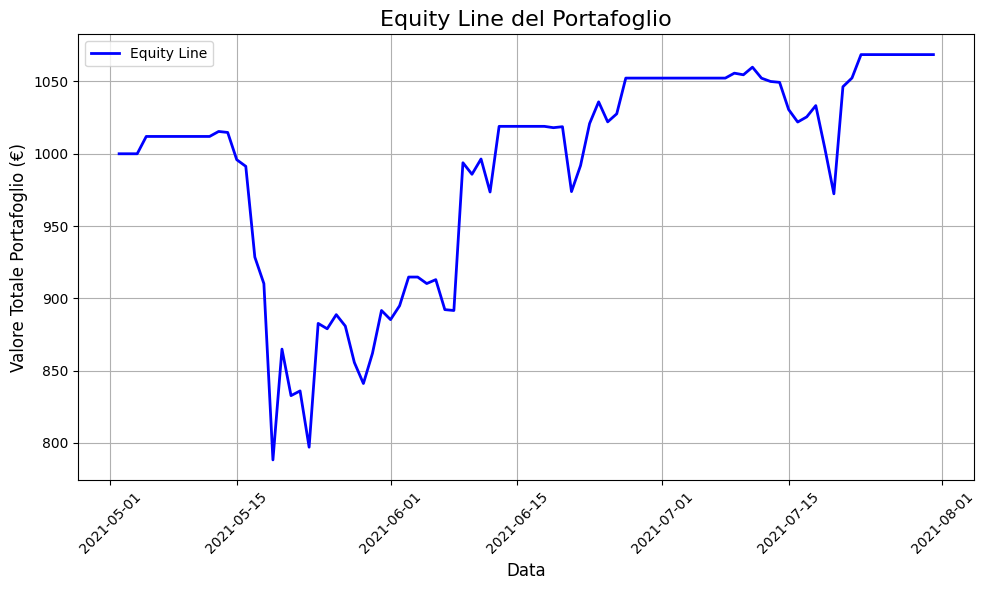

In [229]:
# Assicurati che la colonna 'Data' sia in formato datetime
df_transazioni['data'] = pd.to_datetime(df_transazioni['data'])

# Crea il plot dell'equity line
plt.figure(figsize=(10, 6))
plt.plot(df_transazioni['data'], df_transazioni['valore_totale_portafoglio'], label='Equity Line', color='b', linewidth=2)

# Aggiungi titolo e etichette agli assi
plt.title('Equity Line del Portafoglio', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Valore Totale Portafoglio (€)', fontsize=12)

# Aggiungi una griglia per una migliore leggibilità
plt.grid(True)

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per migliore leggibilità
plt.tight_layout()  # Migliora il layout del grafico
plt.show()

In [230]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

In [231]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidità_iniziale, bitcoin_iniziali, dati['Price'], 0, 0, 0, 0)
print('Rendimento ideale:', rendimento_ideale)
print('Portafoglio finale ideale in euro:', portafoglio_finale_ideale)

Rendimento ideale: 4.389151536150224
Portafoglio finale ideale in euro: 4389.151536150223


In [232]:
valore_iniziale = df_transazioni['valore_totale_portafoglio'].iloc[0]
valore_finale = df_transazioni['valore_totale_portafoglio'].iloc[-1]
rendimento = valore_finale / valore_iniziale

In [233]:
print(f"Rendimento del portafoglio: {rendimento}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Valore finale del portafoglio in euro: {df_transazioni['valore_totale_portafoglio'].iloc[-1]}")

Rendimento del portafoglio: 1.0685970029917649
Punteggio rendimento: 24.35%
Valore finale del portafoglio in euro: 1068.5970029917648


In [234]:
# periodo 1: Dicembre 2020 - Aprile 2021; periodo 2: Maggio 2021 - Luglio 2021; periodo 3: Luglio 2022 - Ottobre 2022

# Set 1:
# inverti_riferimento_acquisto = False
# inverti_riferimento_vendita = True
# acquisto_rispetto_liquidità_iniziale = True
# compra_pure = False
# vendi_pure = True
# soglia_vendita = -np.inf (nessuna soglia specifica per la vendita)
# coefficienti_acquisto = [0, 1.5] (più conservativo)
# coefficienti_vendita = [0, 1.5] (più conservativo)
# compra_solo_in_discesa = True (acquisti solo in discesa)
# vendi_solo_in_salita = True (vendite solo in salita)
# soglia_acquisto_rispetto_riferimento = 0.15 (acquisti solo se sceso almeno del 15% rispetto al riferimento)
# soglia_vendita_rispetto_riferimento = 0.1 (vendite se salito del 10% rispetto al riferimento)
# soglia_calcolo_variazioni_discesa = 0.1 (soglia per individuare trend ribassisti)
# soglia_calcolo_variazioni_salita = 0.1 (soglia per individuare trend rialzisti)

# Set 2:
# inverti_riferimento_acquisto = True
# inverti_riferimento_vendita = False
# acquisto_rispetto_liquidità_iniziale = False
# compra_pure = True
# vendi_pure = True
# soglia_vendita = 0.05 (vendite solo se sopra il 5% rispetto alla media degli acquisti)
# coefficienti_acquisto = [0, 2.5] (aggressivo, acquisti maggiori)
# coefficienti_vendita = [0, 2.5] (aggressivo, vendite maggiori)
# compra_solo_in_discesa = False (puoi comprare anche in salita)
# vendi_solo_in_salita = False (puoi vendere anche in discesa)
# soglia_acquisto_rispetto_riferimento = 0.1 (acquisti se sceso del 10%)
# soglia_vendita_rispetto_riferimento = 0.1 (vendite se salito del 10%)
# soglia_calcolo_variazioni_discesa = 0.05 (individua trend ribassisti con soglia bassa)
# soglia_calcolo_variazioni_salita = 0.05 (trend rialzisti con soglia bassa)

# Set 3:
# inverti_riferimento_acquisto = False
# inverti_riferimento_vendita = True
# acquisto_rispetto_liquidità_iniziale = True
# compra_pure = True
# vendi_pure = False
# soglia_vendita = 0.1 (vendite se sopra il 10% rispetto alla media degli acquisti)
# coefficienti_acquisto = [0, 2] (bilanciato)
# coefficienti_vendita = [0, 2] (bilanciato)
# compra_solo_in_discesa = True
# vendi_solo_in_salita = True
# soglia_acquisto_rispetto_riferimento = 0.05
# soglia_vendita_rispetto_riferimento = 0.05
# soglia_calcolo_variazioni_discesa = 0.1
# soglia_calcolo_variazioni_salita = 0.1

# Set 4:
# inverti_riferimento_acquisto = True
# inverti_riferimento_vendita = True
# acquisto_rispetto_liquidità_iniziale = False
# compra_pure = True
# vendi_pure = True
# soglia_vendita = 0.15 (vendite sopra il 15% rispetto alla media degli acquisti)
# coefficienti_acquisto = [0, 3] (speculativo, acquisti aggressivi)
# coefficienti_vendita = [0, 3] (speculativo, vendite aggressive)
# compra_solo_in_discesa = False
# vendi_solo_in_salita = False
# soglia_acquisto_rispetto_riferimento = 0.15
# soglia_vendita_rispetto_riferimento = 0.15
# soglia_calcolo_variazioni_discesa = 0.15
# soglia_calcolo_variazioni_salita = 0.15

# Risultati:
# Set 1: 33%, -2%, 7%
# Set 2: 44%, -9%, 6%
# Set 3: 88%, -5%, 6%
# Set 4: 26%, 15%, 0%

## Algoritmo con variabili dinamiche tramite grid search integrata